# Analysis of network model results
To do:
* implement, test/check multi-label computations
* implement PR curve


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from keras.models import load_model
from src.models.data import *
from src.models.model import *
from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import skimage.io as io

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

Using TensorFlow backend.


## User settings

In [2]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# base directory with data (image tiles) to be analyzed
eval_dir = "../../data/validate"
# subdirs
dir_x = 'sat'
dir_y = 'map'

# max. number of samples (files) to analyze (predicition takes a long time)
max_num_x = 10

# number of samples to plot in detail
num_x_show = 6

# size of images
target_size = (512,512)

# path to & filename of model to analyze
trained_model_fn = '../../models/unet_membrane_analytic_27_08_14_55.hdf5'
# list any custom loss or metric functions of the model here
custom_objects = {'auc_roc': auc_roc}

# individual samples to be shown: either None, a list of indexes, or any of 'random', 'head_tail'
# in the latter two cases, up to ten images will be picked; head_tail = the five best and the five worst-predicted
#show_samples = "random"
show_samples = "head_tail"

# colormap to be used for prediction scores 
cmap_yscore = 'gray'

### Some constants, preparatory computations & definitions

In [3]:
# label values
CLASS_DICT = {
    "no_img": 0,
    "no_road": 40,
    "paved_road": 127,
    "unpaved_road": 255
}

# colors and other graphics properties to be used for plotting
CLASS_PLOT_PROP = {
    "no_road": ["gray"],
    "paved_road": ["navy"],
    "unpaved_road": ["darkorange"],
    "avg": ["black"]
}

# list of satellite image files & their number
_, _, file_list_x = next(os.walk(os.path.join(eval_dir, dir_x)))
num_x = len(file_list_x)

# actual number of files that will be analyzed, given files available
num_x_use = min(num_x, max_num_x)

# actual number of samples that can be shown, given number of samples to be analyzed
num_x_show = np.min([num_x_show, num_x_use])

def show_tile(tile, ax, cmap=None, show_colorbar=False, title=None):
    im_h = ax.imshow(tile, cmap=cmap);
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if show_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im_h, cax=cax)
    ax.set(title=title)
    return im_h

def multiclass_roc(y, yscore, class_dict=CLASS_DICT, curve=True):
    """
    Perform binary or multi-class roc analysis in which all classes are compared
    to the "no_road" class and data of the "no_img" class are ignored
    y - 1D array of labels
    yscore - array of prediction scores
    class_dict - dictionary listing all legal values in y
    curve - flag indicating whether fpr and tpr for display of curve are to be computed
    """
    debug_mode = False
    # make sure all labels in y actually exist in class_dict
    assert(not set(y).difference(set(class_dict.values()))), "illegal label"
    # remove all entries corresponding to no_img because they are pointless
    good_ix = y != class_dict["no_img"]
    if debug_mode:
        print("excluding {0:0.0f} % non-image pixels)...".format(100*(1.0 - np.sum(good_ix)/y.size)))
        print(good_ix)
    y = y[good_ix]
    yscore = yscore[good_ix]
    if debug_mode:
        print(y)    
    # consider only labels which exist in y
    unique_labels = np.unique(y)
    reduced_class_dict = {list(class_dict.keys())[i]:list(class_dict.values())[i] \
                  for i, val in enumerate(list(class_dict.values())) if val in unique_labels}
    num_label = len(reduced_class_dict)
    if debug_mode:
        print(unique_labels, reduced_class_dict)
    
    # to do: remove corresponding layers (?) in yscore    
    if yscore.ndim >1:
        raise Exception("multi-label scores not yet implemented")
    
    # binarize on all categories found in y
    y_multilabel = label_binarize(y, list(reduced_class_dict.values()))
    # Compute ROC curve and ROC area for each non-no_road class:
    # - allocate
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # keys for fpr, tpr and roc_auc, indicating the class which is tested against no_road
    keys = [k for k in reduced_class_dict.keys() if k != "no_road"]
    # if it's a binary problem, y_multilabel is [nsamples x 1]
    if num_label == 2:
        if curve:
            fpr[keys[0]], tpr[keys[0]], _ = roc_curve(y_multilabel, yscore)
        else:
            fpr[keys[0]], tpr[keys[0]] = None, None
        roc_auc[keys[0]] = roc_auc_score(y_multilabel, yscore)
    elif num_label >= 3:
        raise Exception("multilabel computation of auroc not yet implemented")
        for i in range(1, num_label):
            pass
        # assign averages  
        #fpr["avg"], tpr["avg"], roc_auc["avg"] = fpr[keys[0]], tpr[keys[0]], roc_auc[keys[0]]
    
    return fpr, tpr, roc_auc, reduced_class_dict

def plot_auc_roc(fpr_dict, tpr_dict, auc_roc_dict, ax, plot_prop=CLASS_PLOT_PROP):
    # plot diagonal
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), linestyle='--', color='gray')
    for k in fpr_dict.keys():
        ax.plot(fpr_dict[k], tpr_dict[k],
                label="{0:s}: auc = {1:0.2f}".format(str(k), auc_roc_dict[k]),
               color = plot_prop[k][0])
    ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.set_xticks(np.arange(0, 1.25, 0.25))
    ax.set_ylim(0, 1.01)
    ax.set_xlim(0, 1.01)
    ax.legend(loc="lower right")
    ax.set(title='ROC', xlabel='false positive rate', ylabel='true positive rate')
   



### Load complete model
The additional input arg "custom_objects" is needed if custom loss or metrics were used in the model

In [4]:
model = load_model(trained_model_fn, custom_objects=custom_objects)

### Loop over files, collecting data & predicitions (takes a long time)

In [5]:
# number of pixels per image
img_size = np.prod(target_size)
# preallocate arrays collecting the label (y) values and y scores of all samples
arr_y = np.empty(img_size * num_x_use, dtype=np.uint8)
arr_yscore = np.empty(img_size * num_x_use, dtype=np.float32)
# define key metric
metric = multiclass_roc
# array collecting the key metric for each sample individually
arr_metric = np.empty(num_x_use)

for i, fn in enumerate(file_list_x[:num_x_use]):
    # read sat image tile
    x = io.imread(os.path.join(eval_dir, dir_x, fn))
    # -------------------------------------------------------------------------------- 
    # revise this part if/once non-covered parts of image tiles are labeled as such
    # --------------------------------------------------------------------------------
    # determine invalid pixels (for now defined as those with a vale of zero
    # in the first band). Variable mask could be used to create a masked array,
    # but scikit-learn does not support masked arrays
    mask = x[:,:,0] == 0;
    # scale x
    x = x/255.0
    # read corresponding label tile
    y = io.imread(os.path.join(eval_dir, dir_y, fn))
    # set masked values: first, set zeros in label file to 'no road' value...
    y[np.logical_and(np.logical_not(mask), np.logical_not(y))] = CLASS_DICT["no_road"]
    # then set pixel positions found to not belong to image to 'no_img' value
    y[mask] = CLASS_DICT["no_img"]
    # copy flattened labels in array
    arr_y[i*img_size:(i+1)*img_size] = y.ravel()
    # predict
    print("analyzing {0:s} ({1:0.0f} % non-image pixels)...".format(fn, 100*np.sum(mask)/img_size))
    yscore = model.predict(x.reshape((1,) + target_size +(4,)))
    # copy flattened prediction in array
    arr_yscore[i*img_size:(i+1)*img_size] = yscore.ravel()
    # compute and store metric used for sorting
    _, _, auc_dict, _ = metric(y.ravel(), yscore.ravel(), curve=False)
    if len(auc_dict) == 1:
        # binary labels
        arr_metric[i] = auc_dict[list(auc_dict.keys())[0]]
    else:    
        arr_metric[i] = auc_dict["avg"]


analyzing 20180427_020503_103c_3B_0019.tif (0 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0020.tif (60 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0027.tif (0 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0028.tif (45 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0035.tif (0 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0036.tif (30 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0043.tif (0 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0044.tif (16 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0050.tif (0 % non-image pixels)...
analyzing 20180427_020503_103c_3B_0051.tif (3 % non-image pixels)...


In [6]:
# prepare index for showing samples
if show_samples == "random":
    samples_ix = np.random.choice(num_x_use, num_x_show, replace=False)
elif show_samples == "head_tail":
    # indexes to best and worst examples
    ix_sorted = np.argsort(arr_metric)
    samples_ix = np.hstack((ix_sorted[:(num_x_show//2)],ix_sorted[(-num_x_show//2):]))
elif type(show_samples) is list:
    samples_ix = np.array(show_samples, dtype=int)
    samples_ix = samples_ix[samples_ix < num_x_use]

### Compute and plot metrics on ensemble of data

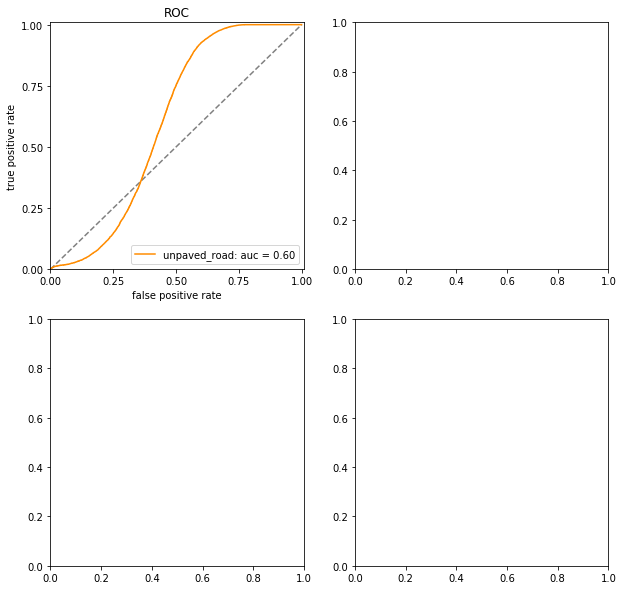

In [7]:
fpr_dict, tpr_dict, roc_auc_dict, reduced_class_dict = multiclass_roc(arr_y, arr_yscore)

# set up summary figure
fig_sum, axs = plt.subplots(2, 2, figsize=(10, 10))
plot_auc_roc(fpr_dict, tpr_dict, roc_auc_dict, axs[0, 0])
plt.show()

### Show individual samples

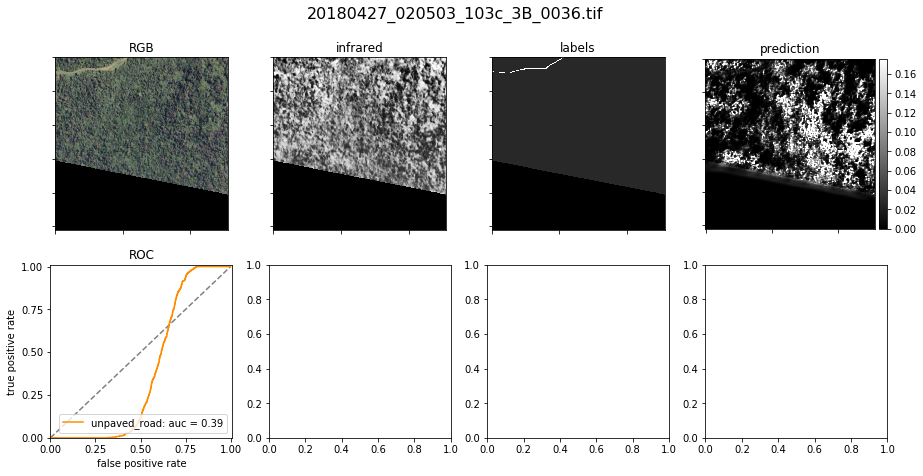

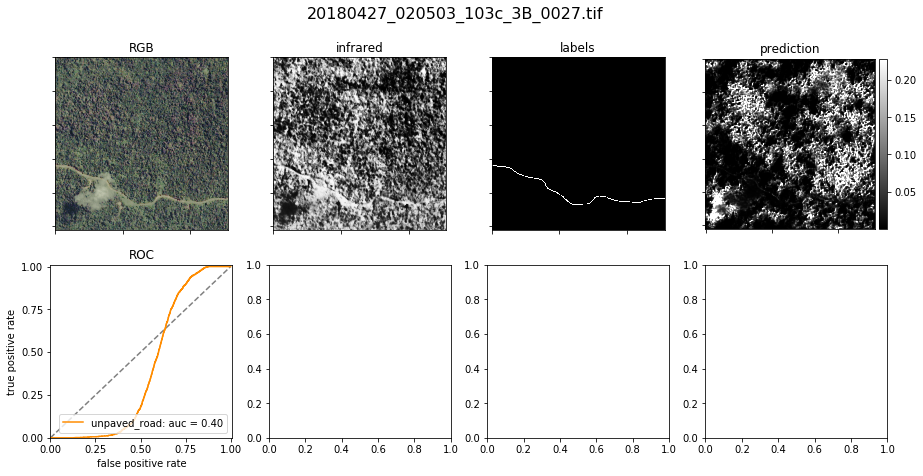

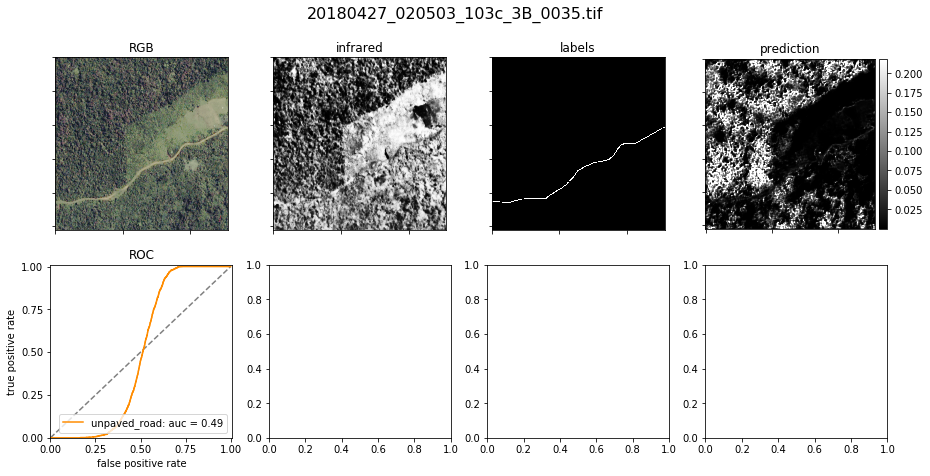

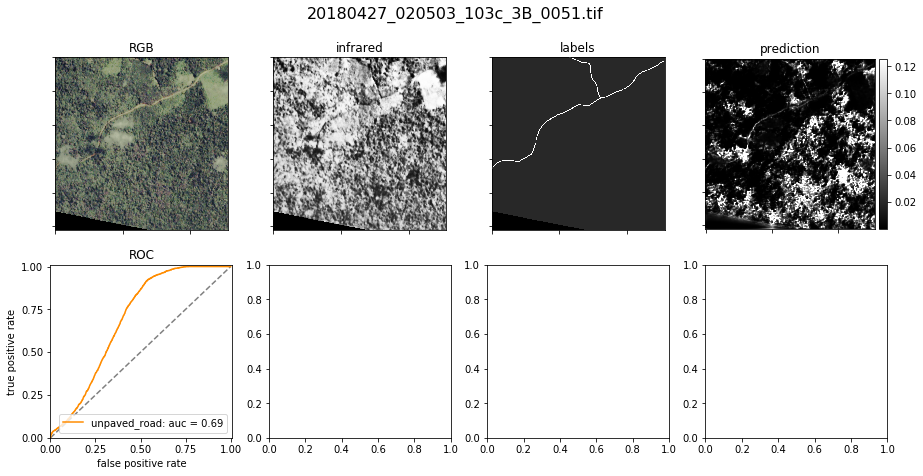

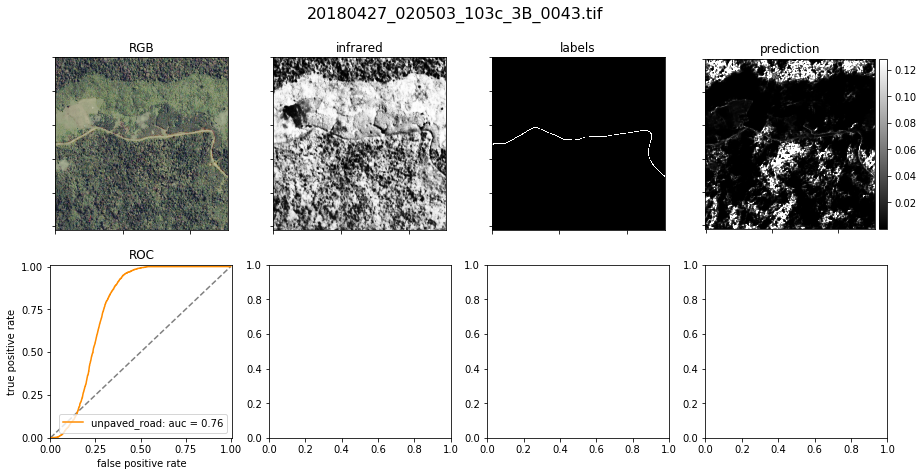

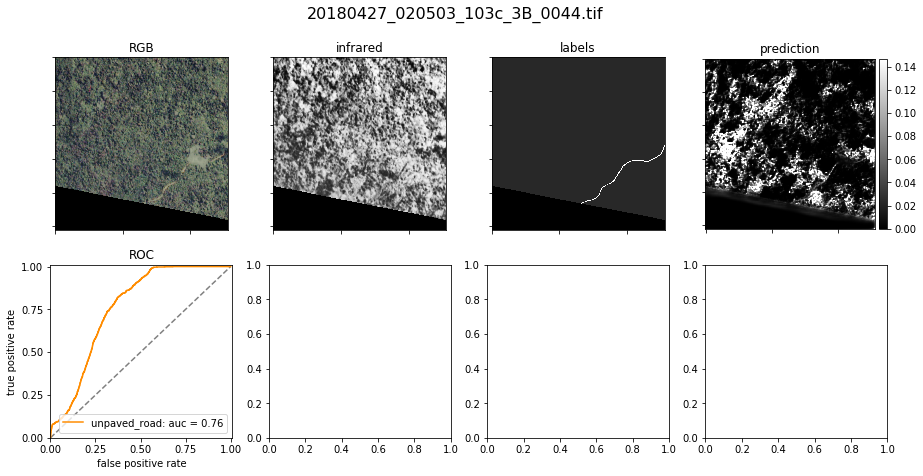

In [8]:
for ix in samples_ix:
    fn = file_list_x[ix]
    # read sat image tile
    x = io.imread(os.path.join(eval_dir, dir_x, fn))
    # retrieve labels
    y = arr_y[ix*img_size:(ix+1)*img_size]
    # retrieve y score (prediction)
    yscore = arr_yscore[ix*img_size:(ix+1)*img_size]
    # make a copy for display in which we get rid of upper small percentile 
    yscore_plot = np.copy(yscore).reshape(target_size)
    prc = np.percentile(yscore_plot, [95.5])
    yscore_plot[yscore_plot >= prc] = prc
    # ----------------set up figure ---------------
    fig_sample, axs = plt.subplots(2, 4, figsize=(15, 7))
    fig_sample.suptitle(fn, fontsize=16)
    # plot rgb part of image
    show_tile(x[:,:,[2, 1, 0]], axs[0,0], title="RGB");
    # nir
    show_tile(x[:,:,3], axs[0,1], cmap="gray",  title="infrared");
    # labels § to be replaced by Lisa's code
    show_tile(y.reshape(target_size), axs[0,2], cmap="gray",  title="labels");
    # y score (prediction)
    show_tile(yscore_plot, axs[0,3], cmap=cmap_yscore, show_colorbar=True,  title="prediction");
    # auc_roc
    fpr_sample_dict, tpr_sample_dict, roc_auc_sample_dict, reduced_label_sample_dict = multiclass_roc(y, yscore)
    plot_auc_roc(fpr_sample_dict, tpr_sample_dict, roc_auc_sample_dict, axs[1, 0])
    plt.show()

In [9]:
# halt
sys.exit()

SystemExit: 

/home/hh/anaconda3/envs/geo/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Outdated stuff
which is not used currently but may come in handy later

In [ ]:
# a quick test of multiclass_roc
multiclass_roc(np.r_[0, 40, 40, 0, 255, 255, 0, 255], np.empty(8))

In [ ]:

# input arguments to Keras' ImageDataGenerator - be sure not to include any image augmentation here!
data_gen_args = dict(data_format="channels_last")

# batch size for summary stats without visualization (the more, the more efficient, but limited by memory)
batch_size = 3


# 'steps' input par into evaluate_generator
steps =  num_x_use // batch_size


### Run evaluation: only numeric values

In [ ]:
# set up test gen with a batch size as large as possible for efficiency reasons
test_gen = trainGenerator(batch_size, eval_dir, img_dir, label_dir,
                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)
res = model.evaluate_generator(test_gen, steps=steps, workers=1, use_multiprocessing=True, verbose=1)

In [ ]:
model.metrics_names
res

### Run prediction for display of images and more sophisticated evaluation

In [ ]:
pred = model.predict_generator(test_gen, steps=steps, workers=1, use_multiprocessing=True, verbose=1)

In [ ]:
plt.imshow(pred[5].reshape(target_size), cmap='gray');
plt.colorbar()

### Set up ImageDataGenerator

In [ ]:
# this generator is supposed to yield single images and matching labels, hence batch size = 1
#batch1_test_gen = trainGenerator(1, eval_dir, img_dir, label_dir,
#                        data_gen_args, save_to_dir = None, image_color_mode="rgba", target_size=target_size)
# preallocate linear arrays for collecting flattened predicition and label data